Comparing Phoenix models with G430L

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

Scaling we can come back to. In most cases, the noisy bit of the G430L spectrum is adequately covered by the NUV spectrum. What about X-shooter?

20210122 making new versions for the MM meeting

In [6]:
stars = ['2MASS-J23062928-0502285',
        'L-980-5',
        'GJ674', 
        'GJ676A',
        'GJ649',
        'GJ699',
        'GJ163',
        'GJ849',
        'GJ1132',
        'LHS-2686',
        'GJ729',
        'GJ15A']

path = '/media/david/2tb_ext_hd/hddata/mega_muscles/hlsp/'

In [7]:
casleo=  glob.glob('../../casleo/*.txt')
print(casleo)
casnums = [os.path.split(cas)[1][2:5] for cas in casleo]
casnums

[]


[]

L-980-5
1.770919845550709e-19
[]
[1.44195955]


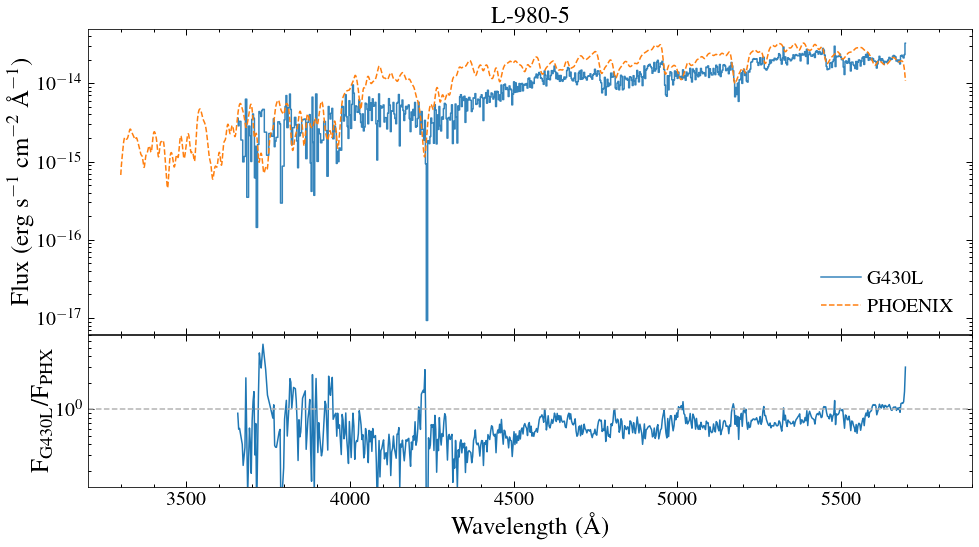

GJ674
3.2132884791074418e-18
[]
[1.14310915]


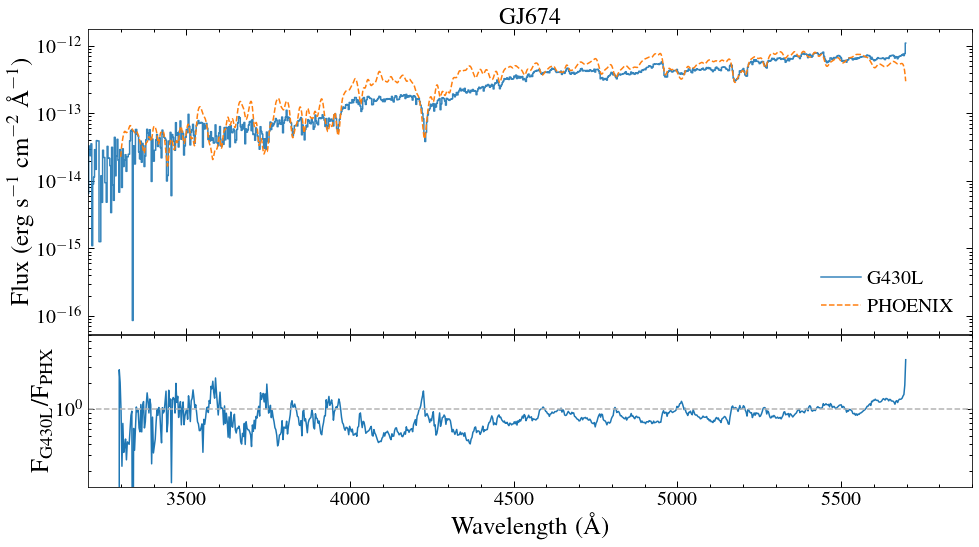

GJ676A
7.772700925412468e-19
[]
[1.55565276]


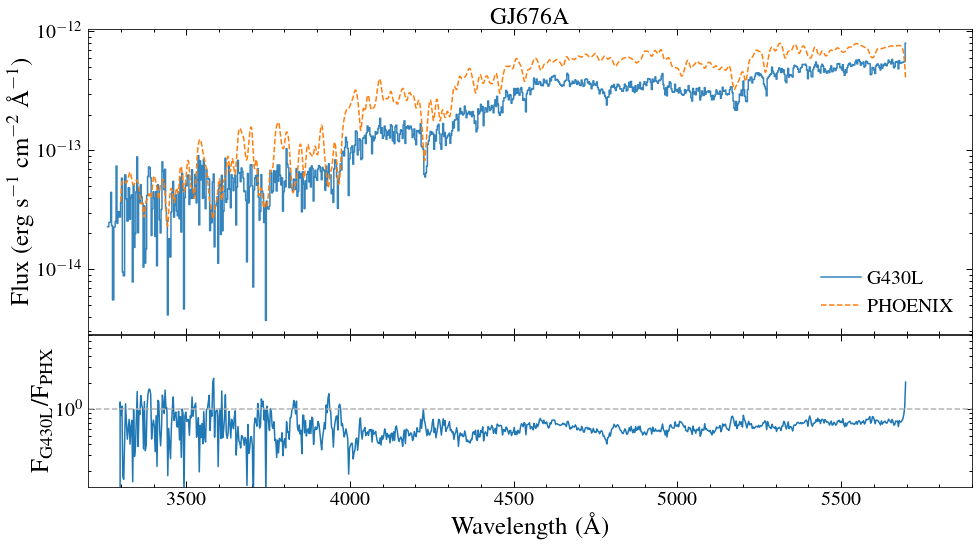

GJ649
1.3313915678661927e-18
[]
[1.11365349]


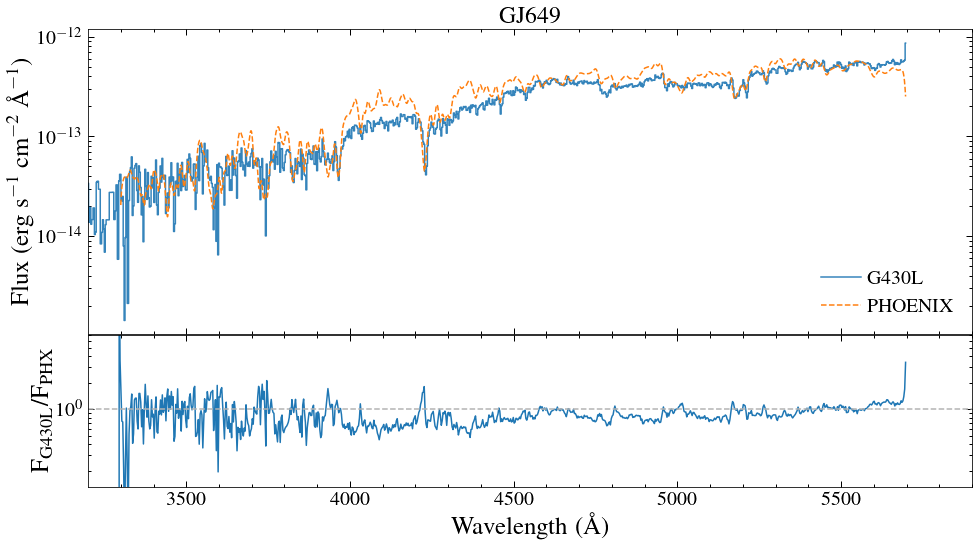

GJ699
5.344147819686864e-18
[]
[1.30069765]


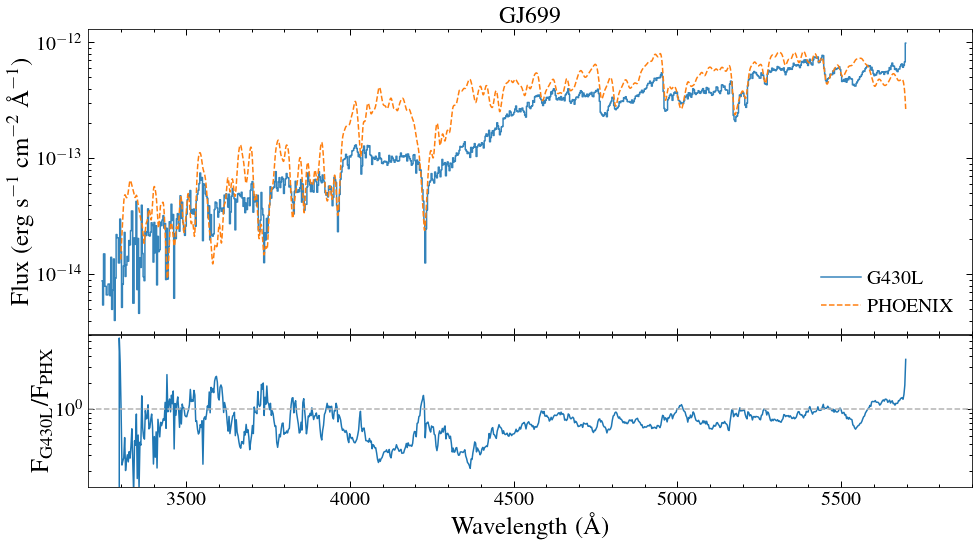

GJ163
3.770574812355878e-19
[]
[1.45600539]


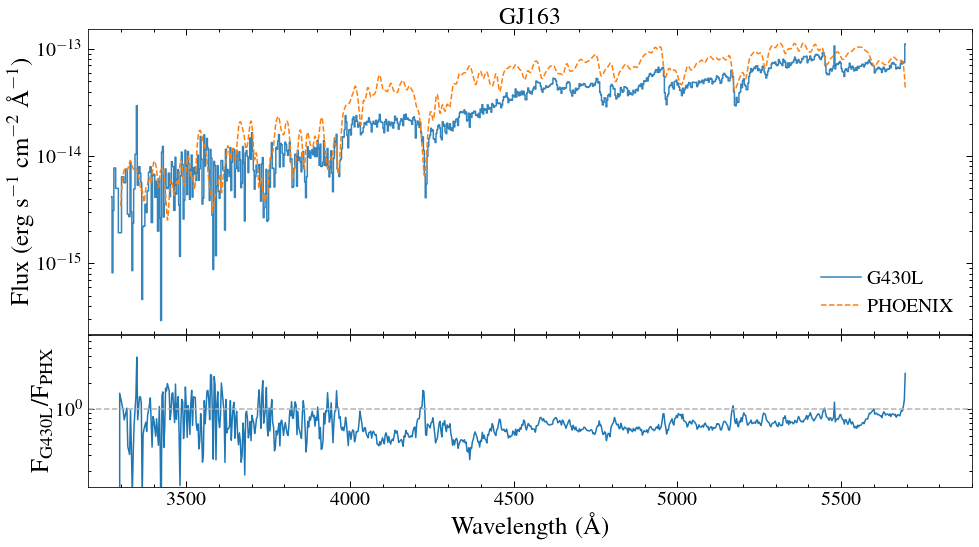

GJ849
1.4036385869722708e-18
[]
[1.681908]


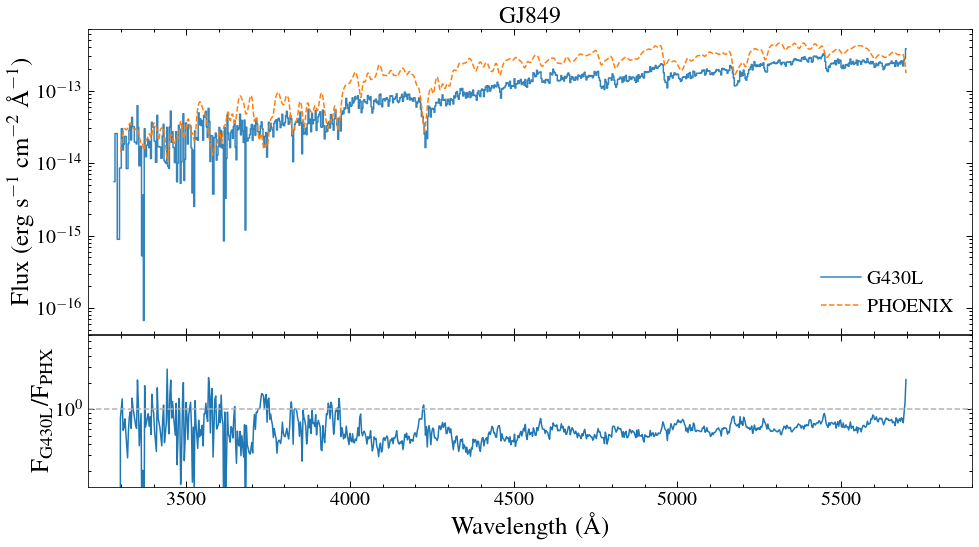

GJ1132
1.621467531871583e-19
[]
[1.43470835]


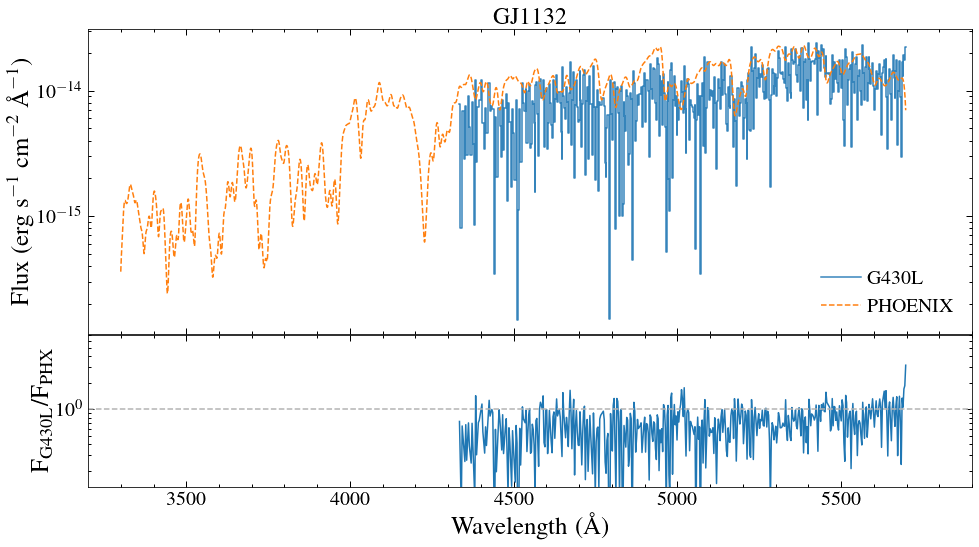

LHS-2686


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


9.751131330068277e-20
[]
[1.55051754]


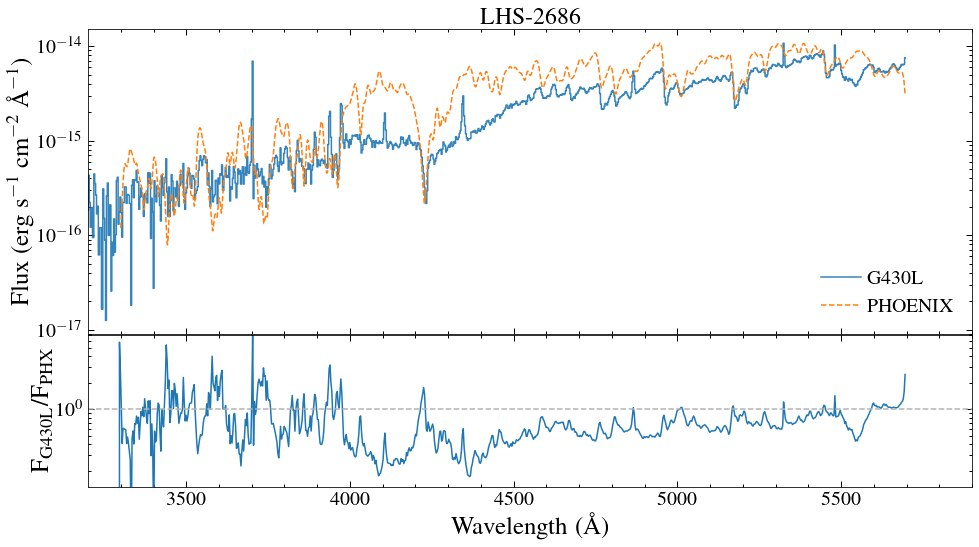

GJ729


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


2.305370508384937e-18
[]
[1.58954501]


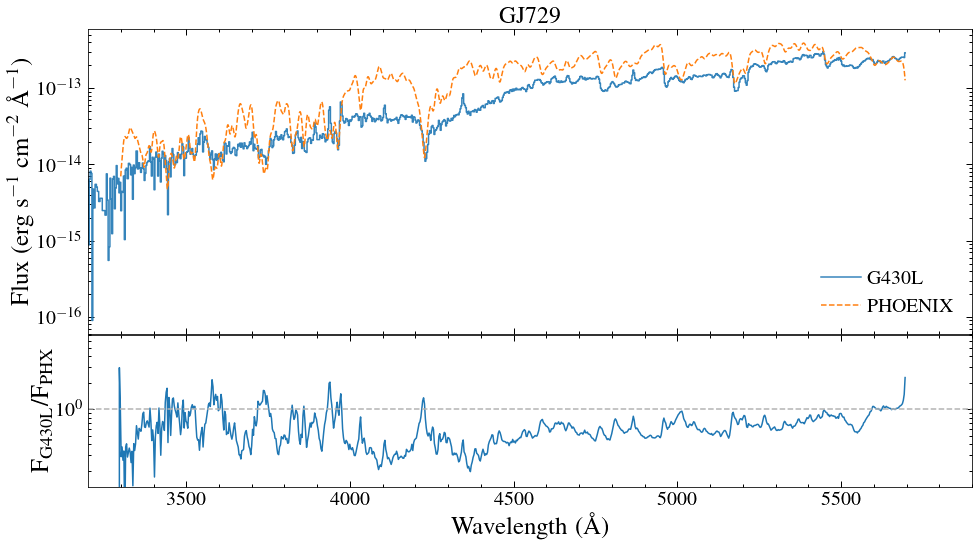

GJ15A


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


5.938448114743541e-18
[]
[1.21930956]


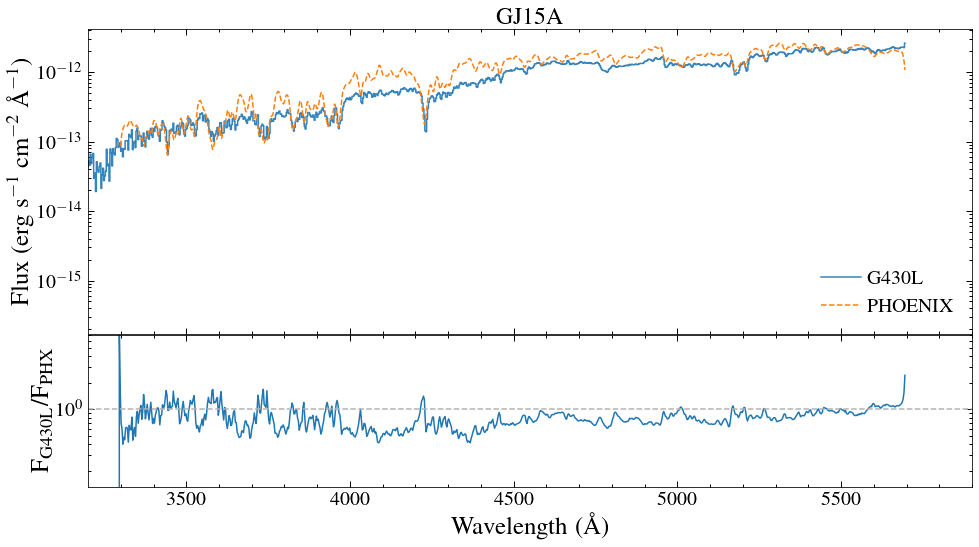

In [8]:
#from matplotlib.gridspec import GridSpec
#import matplotlib.patches as patches
ca =[ 3933.6614, 3968.4673]

xpath = '../../xshooter/archive/'

def residuals(scale, f, mf):
    return f - mf/scale

def normpoint(w, f, wn): #normalise around a point wn
    mask = (w < wn-5) & (w > wn+5)
    fn = np.mean(f[mask])
    return fn

casyn = ['N']
xsyn = ['N']

grating_order = ['G430L']
for star in stars[1:]:
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(6,1, figure=fig)
    ax = plt.subplot(gs[:4])
    print(star)
    spath = glob.glob('{}{}/components_v1/*g430l*ecsv'.format(path, star))
#     specs = glob.glob('../common/stis_test_output/{}/*ecsv'.format(star))
    data= Table.read(spath[0])
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    bin_width = 30
    sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
    start = w[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (w > start) & (f > 0)
    w1, f1 , e1 = w[mask], f[mask], e[mask]
    plt.step(w1, f1, where='mid', label='G430L', c='C0', alpha=0.9)
    
                
               
    opath = glob.glob('{}{}/components_v1/*phx*ecsv'.format(path, star))
    pdata = Table.read(opath[0], data_end= 200000)
    mw, mf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
    print(pdata.meta['NORMFAC'])
    mask = (mw >= 3300) & (mw <=w[-1] ) 
    mw, mf = mw[mask], mf[mask]
    mw, mf = smear(mw, mf, 1000)
    plt.plot(mw, mf, ls='--', label='PHOENIX', c='C1')
    
    if star[2:5] in casnums:
        caspath = glob.glob('../../casleo/*{}*.txt'.format(star[2:5]))
        print(caspath)
        wc, fc = np.loadtxt(caspath[0], unpack=True)
        wc, fc = wc[fc < 1e-12], fc[fc < 1e-12] #one star has a dodgy start
        wc, fc = smear(wc, fc, 1000)
        plt.plot(wc, fc, zorder=-10, label='CASLEO', c='C2', alpha=0.9)
        casyn.append('Y')
    else:
        casyn.append('N')
    
    xfiles = glob.glob('{}{}*UVB.dat'.format(xpath, star))
    print(xfiles)
    if len(xfiles) > 0:
        xw, xf, xe = np.loadtxt(xfiles[0], unpack=True)
        xw *=10
        xmask = (xf > 0) & (xw > 3300) 
        xw, xf = xw[xmask], xf[xmask]
        xw, xf = smear(xw, xf, 1000)
        plt.plot(xw, xf, c='C3', label='X-shooter', zorder=-10, alpha=0.9)
        xsyn.append('Y')
    else:
        xsyn.append('N')
    
    
    plt.legend(loc=4)
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)

#plt.xlabel('Wavelength (\AA)', size=20)
    plt.xticks(visible=False)
    pfr = interpolate.interp1d(mw, mf, fill_value='extrapolate')(w1)
    scale, flag = leastsq(residuals, 1., args=(f1[w1 > 4000], pfr[w1> 4000]))
  #  plt.plot(w1, f1*scale)
    print(scale)
    plt.xlim(3200, 5900)
#     plt.ylim(1.1e-15)

    plt.title(star)
  
    plt.subplot(gs[4:])
    #pwo, pfr = resample.bintogrid(mw, mf, newx=w)
     #print(len(w), len(pwo), len(pfr))
    plt.plot(w1, f1/pfr)
    
    #print(np.median(f1/pfr))
    plt.xlabel('Wavelength (\AA)', size=25)
    plt.ylabel('F$_{\mathrm{G430L}}$/F$_{\mathrm{PHX}}$', size=25)
   # plt.xlim(wo[0]-10, wo[-1]+10)
    plt.axhline(1.0, ls='--', c='0.7')
    plt.yscale('log')
    plt.xlim(3200, 5900)
    plt.ylim(1.3e-1, 0.7e1)
    
 
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.01)
#     plt.savefig('comp_plots/{}_optical.pdf'.format(star), dpi=300)
#     plt.savefig('comp_plots/{}_optical.png'.format(star), dpi=300)
    plt.show()


Just GJ 729 as it has all four

GJ729


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


2.305370508384937e-18
[]
[1.58954501]
3.605551275463989e-16


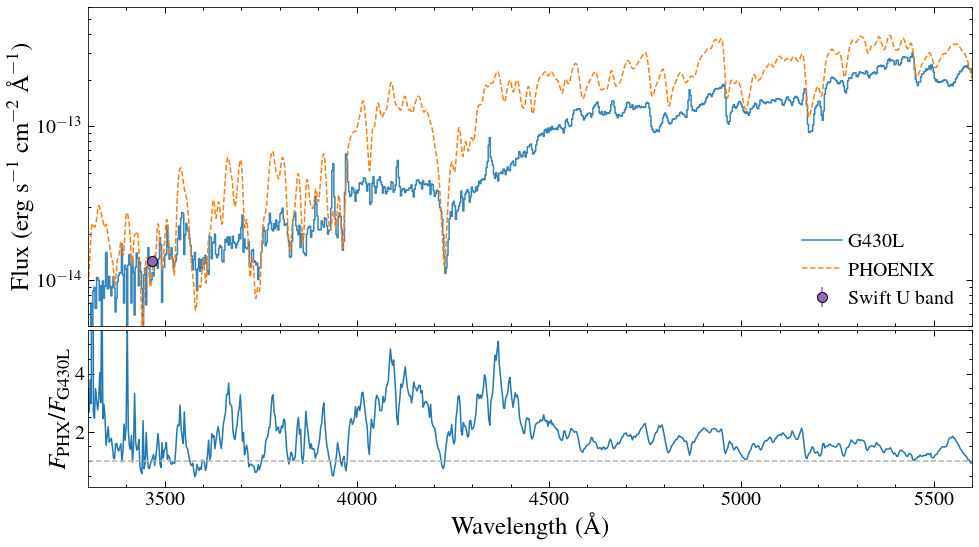

In [9]:
#from matplotlib.gridspec import GridSpec
#import matplotlib.patches as patches
ca =[ 3933.6614, 3968.4673]

xpath = '../../xshooter/archive/'

def residuals(scale, f, mf):
    return f - mf/scale

def normpoint(w, f, wn): #normalise around a point wn
    mask = (w < wn-5) & (w > wn+5)
    fn = np.mean(f[mask])
    return fn

xlims = [3301, 5600]

for star in ['GJ729']:
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(6,1, figure=fig)
    ax = plt.subplot(gs[:4])
    print(star)
    spath = glob.glob('{}{}/components_v1/*g430l*ecsv'.format(path, star))
#     specs = glob.glob('../common/stis_test_output/{}/*ecsv'.format(star))
    data= Table.read(spath[0])
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    bin_width = 30
    sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
    start = w[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (w > start) & (f > 0)
    w1, f1 , e1 = w[mask], f[mask], e[mask]
    plt.step(w1, f1, where='mid', label='G430L', c='C0', alpha=0.9)
    
                
               
    opath = glob.glob('{}{}/components_v1/*phx*ecsv'.format(path, star))
    pdata = Table.read(opath[0], data_end= 200000)
    mw, mf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
    print(pdata.meta['NORMFAC'])
    mask = (mw >= 3300) & (mw <=w[-1] ) 
    mw, mf = mw[mask], mf[mask]
    mw, mf = smear(mw, mf, 1000)
    plt.plot(mw, mf, ls='--', label='PHOENIX', c='C1')
    
    if star[2:5] in casnums:
        caspath = glob.glob('../../casleo/*{}*.txt'.format(star[2:5]))
        print(caspath)
        wc, fc = np.loadtxt(caspath[0], unpack=True)
        wc, fc = wc[fc < 1e-12], fc[fc < 1e-12] #one star has a dodgy start
        wc, fc = smear(wc, fc, 1000)
        plt.plot(wc, fc, zorder=-10, label='CASLEO', c='C2', alpha=0.9)
    
    xfiles = glob.glob('{}{}*UVB.dat'.format(xpath, star))
    print(xfiles)
    if len(xfiles) > 0:
        xw, xf, xe = np.loadtxt(xfiles[0], unpack=True)
        xw *=10
        xmask = (xf > 0) & (xw > 3300) 
        xw, xf = xw[xmask], xf[xmask]
        xw, xf = smear(xw, xf, 1000)
        plt.plot(xw, xf, c='C3', label='X-shooter', zorder=-10, alpha=0.9)
    
    
    
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)

#plt.xlabel('Wavelength (\AA)', size=20)
    plt.xticks(visible=False)
    pfr = interpolate.interp1d(mw, mf, fill_value='extrapolate')(w1)
    scale, flag = leastsq(residuals, 1., args=(f1[w1 > 4000], pfr[w1> 4000]))
  #  plt.plot(w1, f1*scale)
    print(scale)
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(5e-15, 6e-13)

#     plt.title(star)
  
    #swift u band
    swift_w = 3467.05
#     swift_f = 1.529230894365945e-14
#     swift_e = 2.160386205122546e-17
    swift_f = 1.32e-14 #from uvot source
    swift_e = 1e-14*(0.03**2+0.02**2)**0.5 #stat+sys
    print(swift_e)

    
    plt.errorbar(swift_w, swift_f, yerr=swift_e, marker='o', ls='none', c= 'C4', markeredgecolor='k', label = 'Swift U band', markersize=10) 
    
    plt.legend(loc=4)
    plt.subplot(gs[4:])
    #pwo, pfr = resample.bintogrid(mw, mf, newx=w)
     #print(len(w), len(pwo), len(pfr))
    plt.plot(w1, pfr/f1)
    
    #print(np.median(f1/pfr))
    plt.xlabel('Wavelength (\AA)', size=25)
    plt.ylabel('$F_{\mathrm{PHX}}$/$F_{\mathrm{G430L}}$', size=25)
   # plt.xlim(wo[0]-10, wo[-1]+10)
    plt.axhline(1.0, ls='--', c='0.7')
#     plt.yscale('log')
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(0.1, 5.5)
    
    
   

    
 




    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.savefig('plots/gj729_optical.pdf'.format(star), dpi=300)
    plt.savefig('plots/gj729_optical.png'.format(star), dpi=300)
    plt.show()


In [10]:
for star, c, x in zip(stars, casyn, xsyn):
    print('{} & {} & {} \\\\'.format(star, c, x))

2MASS-J23062928-0502285 & N & N \\
L-980-5 & N & N \\
GJ674 & N & N \\
GJ676A & N & N \\
GJ649 & N & N \\
GJ699 & N & N \\
GJ163 & N & N \\
GJ849 & N & N \\
GJ1132 & N & N \\
LHS-2686 & N & N \\
GJ729 & N & N \\
GJ15A & N & N \\
